In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import stats

import pandas as pd

In [47]:
def simulate_phylo_mutations(num_generations, p, q):
    """
    Basic simulation for calculating the number of times a state will appear on a character over a number of generations.
    
    p: probability of the character mutating.
    q: conditional probability of the state arising given the character has mutated to.
    num_generations: number of generations to simulate.
    
    returns:
        - number of times that the character mutated
        - number of times that the state arose on the character.
    
    """
    
    
    pop_size = 1 #number of cells with no mutation
    type1 = 0 #number of times character mutated
    type2 = 0 #number of times character mutated to particular state
    for t in range(num_generations):
        if pop_size == 0:
            break
        pop_size *= 2 #every cell divides
        num_type1 = np.random.binomial(pop_size, p) #each unmutated offspring this generation mutates independently with probability p
        pop_size -= num_type1 #cells that mutated can no longer produce offspring capable of mutating again
        type1 += num_type1
        type2 += np.random.binomial(num_type1, q)
    return type1, type2

def simulate_observed_frequency(num_generations, p, q):
    """
    Simulation for relating the observed frequency of a given mutation to the number of times that it occurred in the phylogeny. 
    
    args:
        num_generations: number of generations to simulate
        p: probability of the character mutating 
        q: conditional probability of the state arising given the character has mutated to.
        
    returns:
        - number of times that the state apperaed.
        - number of times that the state is observed at the leaves.
    """
    
    pop_size = 2 #number of cells with no mutation
    num_mutations = 0 #number of mutations in simulation so far
    num_mutated = 0
    D = np.zeros(num_generations)
    for t in range(num_generations):
        D[t] = np.random.binomial(pop_size, p)
        pop_size = 2*(pop_size - D[t])
        num_mutations_type_2 = np.random.binomial(D[t], q)
        num_mutated += num_mutations_type_2*2**(num_generations - t -1)
        num_mutations += num_mutations_type_2
    return num_mutations, num_mutated/2**num_generations


## X = Number of times a state (indel) arose in a phylogeny
## Y = Observed frequency of the mutation at the leaves (between 0 and 1)

def eX(p, q, h):
    if p == 0.5:
        return 2*p*q*(h-1)
    return (2*q*p*(1-(2-2*p)**h)/(2*p-1))

def VarX(p, q, h):
    def cross_terms(p, q, h):
        if p == 0.5:
            return p**2*q**2*sum([(h-d)**2 for d in range(h)])
        s = 0
        for d in range(h):
            s += ((2-2*p)**d)*((2-2*p)**(h-d)-1)**2
        return p**2*q**2*s/(2*p-1)**2
    return 2*cross_terms(p,q,h) + eX(p,q,h) - eX(p,q,h)**2

def eY(p, q, h):
    return q*(1-(1-p)**h)

def Var_Y(p,q,h):
    Ey = q*(1-(1-p)**h)
    s = 0
    s += 2*(1-((1-p)/2)**h)/(1+p) - 4*(1-p)**h*(1-2**(-h)) + (2-2*p)*(1-p)**(2*h)*(1-(1/(2-2*p))**h)/(1-2*p)
    Eyiyj = q**2*s/4
    Eyiyi = p*q*(1-((1-p)/2)**h)/(1+p)
    return 2*Eyiyj + Eyiyi - Ey**2

def CoV(p, q, h):
    s = 2*(2-2*p)**h*(1-2**(-h)) - (2-2*p)*(1-p)**h*((2-2*p)**h - 1)/(1-2*p) - (1-(1-p)**h)/p + h*(1-p)**h
    twoExiyj = p*q**2*s/(1-2*p)
    Ey = q*(1-(1-p)**h)
    Ex = (2*q*p*(1-(2-2*p)**h)/(2*p-1))
    return twoExiyj + Ey - Ex*Ey

## 1. Compare Expected Number of Mutations to those Observed in Simulation

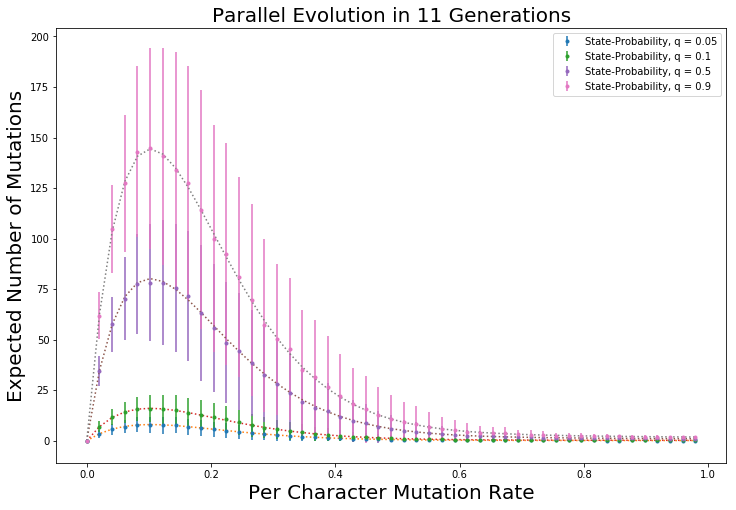

In [48]:
intervals = 49
trials = 1000
NUM_GEN = 11

f = plt.figure(figsize = (12,8))
for q in [0.05, 0.1, 0.5, 0.9]:
    p_array = np.zeros(intervals)
    mu_array = np.zeros(intervals)
    sdv_array = np.zeros(intervals)
    mu_array2 = np.zeros(intervals)
    sdv_array2 = np.zeros(intervals)
    predicted_t1 = np.zeros(intervals)
    predicted_t2 = np.zeros(intervals)
    for i in range(intervals):
        p  = i/intervals
        p_array[i] = p
        mutation_tally = np.zeros(trials)
        mutation_tally2 = np.zeros(trials)
        for j in range(trials):
            mutation_tally[j], mutation_tally2[j] = simulate_phylo_mutations(NUM_GEN, p, q)
        mu_array[i] = np.average(mutation_tally)
        sdv_array[i] = np.std(mutation_tally)#/np.sqrt(trials)
        mu_array2[i] = np.average(mutation_tally2)
        sdv_array2[i] = np.std(mutation_tally2)#/np.sqrt(trials)
        predicted_t2[i] = eX(p, q, NUM_GEN)
        
        

    plt.errorbar(p_array, mu_array2, yerr=sdv_array2, marker='o', markersize='3', ls='none', label='State-Probability, q = ' + str(q))
    plt.plot(p_array, predicted_t2, ls='dotted')

plt.title("Parallel Evolution in 11 Generations")
plt.xlabel("Per Character Mutation Rate")
plt.ylabel("Expected Number of Mutations")   
plt.legend()
plt.rc('axes', labelsize = 20)
plt.rc('axes', titlesize = 20)

plt.show()

## 2. Determing Relationship between Frequency of Observed Mutation to the Number of Times it Occurred in Phylogeny

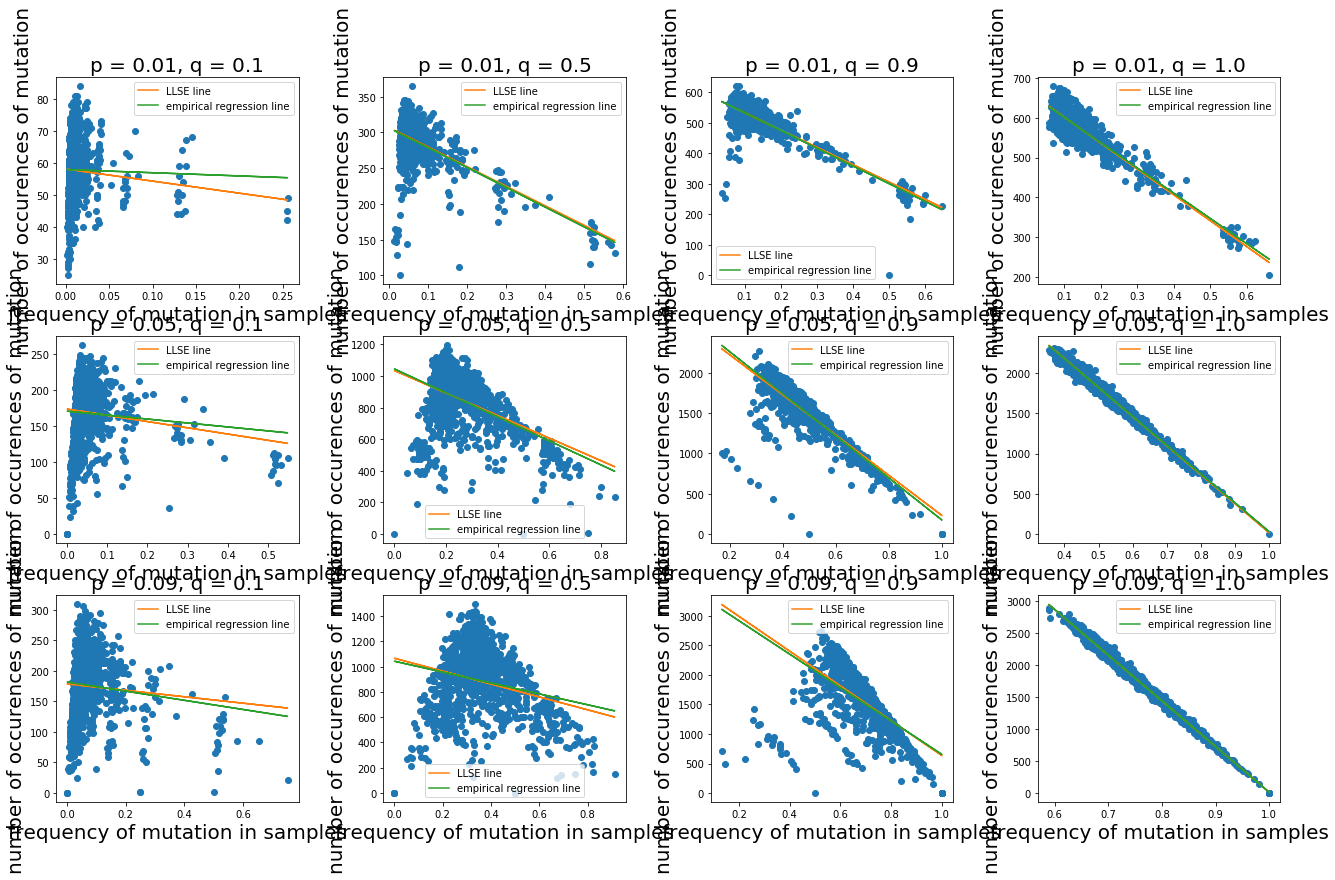

In [56]:
intervals_1 = 10
intervals_2 = 10
h = 15
fig, axes = plt.subplots(3,4, figsize = (20, 12))

i1, i2 = 0, 0
for i in [1,5,9]:
    p = i/(10*intervals_1)
    i2 = 0
    for k in [1,5,9, 10]:
        q = k/intervals_2
        x = np.zeros(1000)
        y = np.zeros(1000)
        for j in range(1000):
            y[j], x[j] = simulate_observed_frequency(h, p, q)
        results = stats.linregress(x, y)
        slope, intercept = results[0], results[1]
        llse_slope = CoV(p,q,h)/Var(p,q,h)
        llse_intercept = eX(p,q,h) - CoV(p,q,h)/Var(p,q,h)*eY(p,q,h)
        line1 = x*llse_slope + llse_intercept
        line2 = x*slope + intercept
        
        #f = plt.figure()
        axes[i1, i2].plot(x, y, 'o')
        axes[i1, i2].plot(x, line1, label='LLSE line')
        axes[i1, i2].plot(x, line2, label='empirical regression line')
        axes[i1, i2].set_xlabel("frequency of mutation in samples")
        axes[i1, i2].set_ylabel("number of occurences of mutation")
        axes[i1, i2].legend()
        axes[i1, i2].set_title("p = " + str(p) + ", q = " + str(q))
        
        i2 += 1
    i1 += 1
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()
